# Using GANs and Keras

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image

from tensorflow.examples.tutorials.mnist import input_data


In [3]:
import tensorflow.keras.backend as ktf
import tensorflow as tf
import os

def get_session(gpu_fraction=0.45):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

ktf.set_session(get_session())

## Defining the discriminator (aka encoder)

In our two-player game the discriminator takes the role of the police: given an image it has to find out whether the image is fake or not. Given this requirement, the input of our discriminator network is a (28x28x1) input patch, equal to the dimensions of an MNIST image. The output is a single node. The setup of the networks is roughly based on the [DCGAN paper](https://arxiv.org/abs/1511.06434) and one of its [implementations](https://github.com/carpedm20/DCGAN-tensorflow).

We use `LeakyReLU` in between the convolution layers to improve the gradients. 

In [4]:
def discriminator():
    
    net = Sequential()
    input_shape = (28, 28, 1)
    dropout_prob = 0.4

    net.add(Conv2D(64, 5, strides=2, input_shape=input_shape, padding='same'))
    net.add(LeakyReLU())
    
    net.add(Conv2D(128, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(256, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(512, 5, strides=1, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Flatten())
    net.add(Dense(1))
    net.add(Activation('sigmoid'))
    
    return net

The full network structure is as follows:

In [5]:
net_discriminator = discriminator()
net_discriminator.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)    

# Defining the generator (aka decoder)

The task of the generator, also known as "the counterfeiter", is to fool the discriminator by producing real-looking fake images. These images should eventually resemble the data distribution of the MNIST dataset.

The structure of the generator is comparable to the discrminiator but in reverse. We start with a random vector of noise (length=100) and gradually upsample. To improve the output of the generator we use `UpSampling2D` and normal convolutions instead of transposed convolutions (see also [this article](https://distill.pub/2016/deconv-checkerboard/)). The sizes of the layers are adjusted to match the size of our data (28x28 as opposed to the 64x64 of the DCGAN paper).

In [47]:
def generator():
    
    net = Sequential()
    dropout_prob = 0.4
    
    net.add(Dense(7*7*256*3, input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    net.add(Reshape((7,7,256)))
    net.add(Dropout(dropout_prob))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(UpSampling2D())
    net.add(Conv2D(64, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(32, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(1, 5, padding='same'))
    net.add(Activation('sigmoid'))
    
    return net

The full network of the generator looks as follows:

In [48]:
net_generator = generator()
net_generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 37632)             3800832   
_________________________________________________________________
batch_normalization_v1_9 (Ba (None, 37632)             150528    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 37632)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 128)       819328    
__________

# Creating the models

We now defined the two separate networks but these still need to be combined in to two trainable models: one to train the discrmininator and one to train the generator. We first start with the most simple one which is the discriminator model.

For the discriminator model we only have to define the optimizer, all the other parts of the model are already defined. We use `SGD` as the optimizer with a low learning rate and clip the values between -1 and 1. A small decay in the learning rate can help with stabilizing. Besides the loss we also tell Keras to gives us the accuracy as a metric.

In [49]:
optim_discriminator = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-10)
model_discriminator = Sequential()
model_discriminator.add(net_discriminator)
model_discriminator.compile(loss='binary_crossentropy', optimizer=optim_discriminator, metrics=['accuracy'])

model_discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1)                 4311553   
Total params: 4,311,553
Trainable params: 0
Non-trainable params: 4,311,553
_________________________________________________________________


The model for the generator is a bit more complex. The generator needs to fool the discriminator by generating images. To train the generator we need to assess its performance on the output of the discriminator. For this we add both networks to a combined model: *the adversarial model*. Our adverserial model uses random noise as its input and outputs the eventual prediction of the discriminator on the generated images. 

The generator performs well if the adverserial model outputs 'real' on all inputs. In other words, for any input of the adversial network aim to get an output classifying the generated image as real. This means, however, that the discriminator failed (which is a good thing for the generator). If we would use normal back propagation here on the full adversarial model we would update slowly push the discriminator to update itself and start classifying fake images as real. To prevent this we must freeze the part of the model that belongs to the discriminator.

In Keras freezing a model is easily done by freezing all the layers of the model. By setting the `trainable` parameter to `False` we prevent the layer of updating within this particular model (it is still trainable in the discriminator model).

The adversarial model uses `Adam` as the optimizer with the default values for the momentum.

In [50]:
optim_adversarial = Adam(lr=0.0004, clipvalue=1.0, decay=1e-10)
model_adversarial = Sequential()
model_adversarial.add(net_generator)

# Disable layers in discriminator
for layer in net_discriminator.layers:
    layer.trainable = False

model_adversarial.add(net_discriminator)
model_adversarial.compile(loss='binary_crossentropy', optimizer=optim_adversarial, metrics=['accuracy'])

model_adversarial.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 28, 28, 1)         5028481   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 4311553   
Total params: 9,340,034
Trainable params: 4,952,769
Non-trainable params: 4,387,265
_________________________________________________________________


Note that the number of non-trainable parameters is very high. This is exactly what we want! 



# Reading MNIST data

We can now read our training data. For this I use a small utility function from Tensorflow.

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
55000


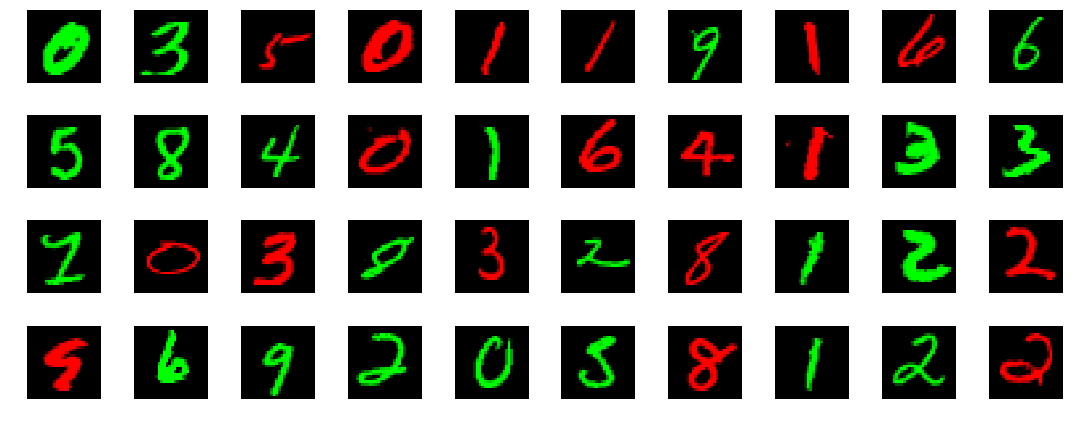

In [51]:
# Read MNIST data
x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)

n = x_train.shape[0]
print n

new_x_train = np.zeros((n, 28, 28, 3))
for i in range(n):
    img = np.reshape(x_train[i], (28, 28, 1))
    if np.random.random() < 0.5: # turn red
        new = np.concatenate([img, np.zeros(( 28, 28, 1)), np.zeros(( 28, 28, 1))], axis=2)
    else: # turn green
        new = np.concatenate([np.zeros(( 28, 28, 1)), img, np.zeros(( 28, 28, 1))], axis=2)
    new_x_train[i] = new

plt.figure(figsize=(15,6))
images = new_x_train[np.random.randint(0, x_train.shape[0], size=40), :, :, :]

for i in range(40):
    
    image = images[i, :, :, :]
    image = np.reshape(image, [28, 28, 3])
    plt.subplot(4, 10, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Load MNIST data from keras
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# # Convert pixel values from 0 to 255 to [0,1] range
# x_train = x_train/255.
# x_test = x_test/255.

# Map the images to a new range [-1, 1]
#x_train = x_train / 0.5 - 1


# Training the GAN

With our models defined and the data loaded we can start training our GAN. The models are trained one after another, starting with the discriminator. The discriminator is trained on a data set of both fake and real images and tries to classify them correctly. The adversarial model is trained on noise vectors as explained above.



In [52]:
batch_size = 16

vis_noise = np.random.uniform(-1.0, 1.0, size=[16, 100])

loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []

for i in range(101):
    
    # Select a random set of training images from the mnist dataset
    images_train = new_x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
    # Generate a random noise vector
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    # Use the generator to create fake images from the noise vector
    images_fake = net_generator.predict(noise)
    print images_fake.shape
    
    # Create a dataset with fake and real images
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0 

    # Train discriminator for one batch
    d_stats = model_discriminator.train_on_batch(x, y)
    
    # Train the generator
    # The input of th adversarial model is a list of noise vectors. The generator is 'good' if the discriminator classifies
    # all the generated images as real. Therefore, the desired output is a list of all ones.
    y = np.ones([batch_size, 1])
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    a_stats = model_adversarial.train_on_batch(noise, y)
        
    if i % 5 == 0:
        plot_iteration.append(i)
        loss_adv.append(a_stats[0])
        loss_dis.append(d_stats[0])
        acc_adv.append(a_stats[1])
        acc_dis.append(d_stats[1])

        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(16, 8)

        ax1.plot(plot_iteration, loss_adv, label="loss adversarial")
        ax1.plot(plot_iteration, loss_dis, label="loss discriminator")
        ax1.set_ylim([0,5])
        ax1.legend()

        ax2.plot(plot_iteration, acc_adv, label="acc adversarial")
        ax2.plot(plot_iteration, acc_dis, label="acc discriminator")
        ax2.legend()

        plt.show()
       
    # Optional, print losses instead of plotting with:
    print("{}: [Dis. loss: {:.4f}, acc: {:.4f}] [Gen. loss: {:.4f}, acc: {:.4f}]".format(i, d_stats[0], d_stats[1], a_stats[0], a_stats[1]))

    if i % 50 == 0:
        # Visualize the performance of the generator by producing images from the test vector
        images = net_generator.predict(vis_noise)
        # Map back to original range
        #images = (images + 1 ) * 0.5
        plt.figure(figsize=(10,10))
        
        for im in range(images.shape[0]):
            plt.subplot(4, 4, im+1)
            image = images[im, :, :, :]
            image = np.reshape(image, [28, 28])
            
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(r'output/mnist-normal/{}.png'.format(i))
        plt.close('all')

InvalidArgumentError: Input to reshape is a tensor with 602112 values, but the requested shape has 200704
	 [[{{node reshape_3/Reshape}}]]

In [37]:
import imageio

filenames = [r'output/mnist-normal/{}.png'.format(i * 50) for i in range(3)]
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(r'output/mnist-normal/learning.gif', images, duration=0.5)

Image(url='output/mnist-normal/learning.gif')  

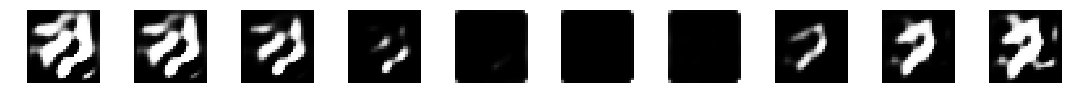

In [38]:
plt.figure(figsize=(15,4))

for i in range(10):
    noise = np.zeros([1,100]) - 1 + (i * 0.2)
    images = net_generator.predict(noise)
    
    image = images[0, :, :, :]
    image = np.reshape(image, [28, 28])
          
    plt.subplot(1, 10, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
    
    

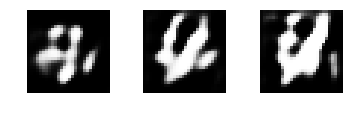

In [39]:
a = np.random.uniform(-1.0, 1.0, size=[1, 100])
b = np.random.uniform(-1.0, 1.0, size=[1, 100])

image_a = np.reshape(net_generator.predict(a)[0], [28, 28])
image_b = np.reshape(net_generator.predict(b)[0], [28, 28])
image_sum = np.reshape(net_generator.predict(b - a)[0], [28, 28])

plt.figure(figsize=(5,4))

plt.subplot(1,3,1)
plt.imshow(image_a, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(image_b, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(image_sum, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

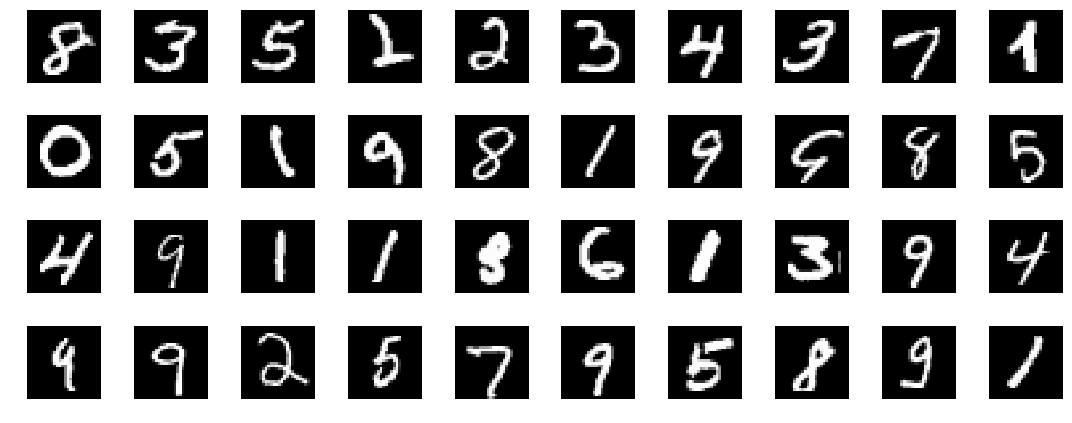

In [40]:
plt.figure(figsize=(15,6))
images = x_train[np.random.randint(0, x_train.shape[0], size=40), :, :, :]

for i in range(40):
    
    image = images[i, :, :, :]
    image = np.reshape(image, [28, 28])
    plt.subplot(4, 10, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
    

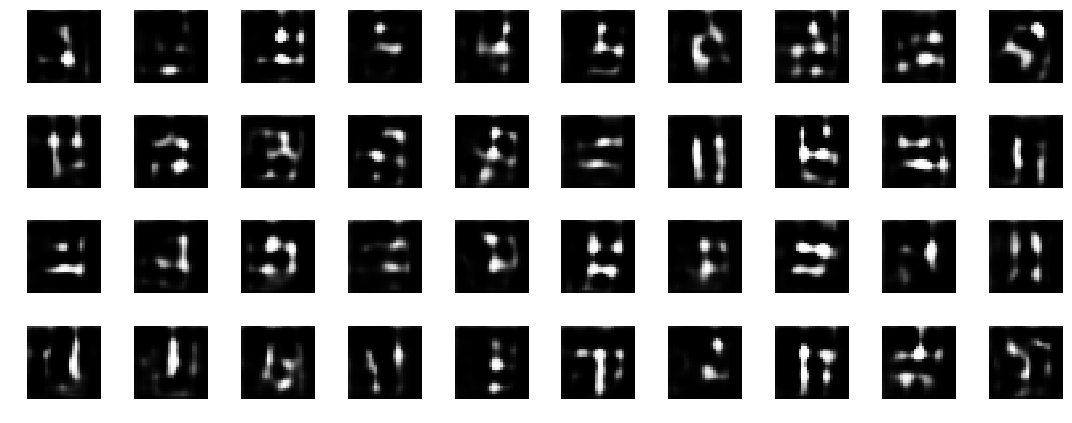

In [16]:
plt.figure(figsize=(15,6))
noise = np.random.uniform(-1.0, 1.0, size=[40, 100])
images = net_generator.predict(noise)

for i in range(40):
    
    image = images[i, :, :, :]
    image = np.reshape(image, [28, 28])
          
    plt.subplot(4, 10, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

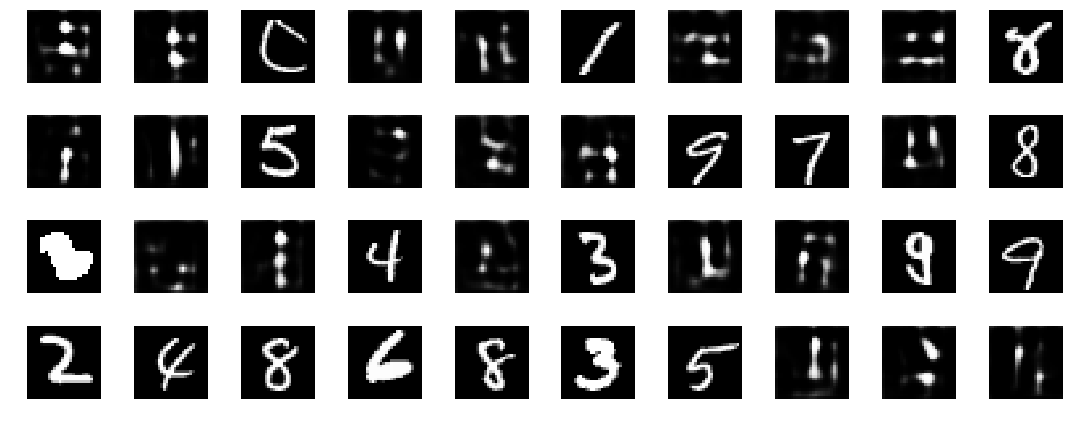

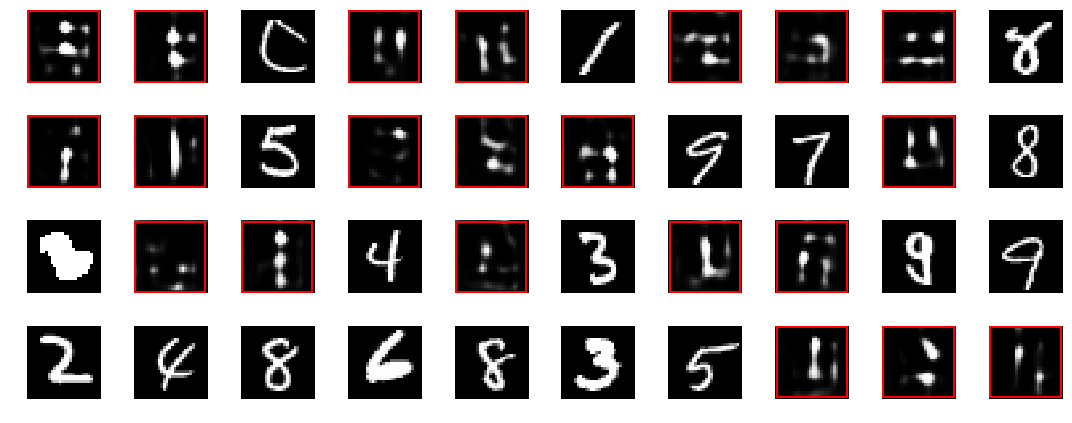

In [17]:
import matplotlib.patches as plot_patch

plt.figure(figsize=(15,6))
noise = np.random.uniform(-1.0, 1.0, size=[40, 100])
images_fake = net_generator.predict(noise)
images_real = x_train[np.random.randint(0, x_train.shape[0], size=40), :, :, :]
choice_vector = np.random.uniform(0, 1, size=40)

for i in range(40):
    
    if choice_vector[i] > 0.5:
        image = images_fake[i, :, :, :]
    else:
        image = images_real[i]
    image = np.reshape(image, [28, 28])

    plt.subplot(4, 10, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15,6))

border = np.zeros((28,28,3))
border[0,:] = [255,0,0]
border[:,0] = [255,0,0]

for i in range(40):
    
    if choice_vector[i] > 0.5:
        image = images_fake[i, :, :, :]
    else:
        image = images_real[i]
    image = np.reshape(image, [28, 28])
    
    ax = plt.subplot(4, 10, i+1)
    plt.imshow(image, cmap='gray')
    if choice_vector[i] > 0.5:
        ax.add_patch(plot_patch.Rectangle((0,0), 27, 27, edgecolor="red", linewidth=2, fill=False))   
    plt.axis('off')

plt.tight_layout()
plt.show()